In [11]:
# Add scripts to path and fix working directory
import sys
import os
from pathlib import Path

# Set project root explicitly - notebook is in scripts/notebooks/
project_root = Path(__file__).parent.parent.parent if '__file__' in locals() else Path("/home/Plutonium/Documents/BioinfoMidterm")

os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module (not individual objects) so we get updated values after set_population_config
import config as cfg

# Set population config FIRST - this updates cfg.PATHS and cfg.POPULATIONS
cfg.set_population_config("sea_jpt_cn")

# Now import other modules
from utils import analyze_hardy, count_variants
from situational_filters import (
    calculate_hwe_stats,
    filter_hwe,
    set_variant_ids,
    calculate_ld_prune_list,
    apply_ld_prune_list,
    filter_ld,
    apply_all_situational_filters,
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create aliases for convenience (now pointing to sea_jpt_cn config)
PATHS = cfg.PATHS
POPULATIONS = cfg.POPULATIONS
SITUATIONAL_FILTERS = cfg.SITUATIONAL_FILTERS

cfg.print_config_summary()

# Configuration summary
print("\nSITUATIONAL FILTER SETTINGS")
print("="*60)
print(f"HWE threshold: {SITUATIONAL_FILTERS.HWE_P_THRESHOLD} (ADJUSTABLE)")
print(f"LD window: {SITUATIONAL_FILTERS.LD_WINDOW_KB}kb (ADJUSTABLE)")
print(f"LD step: {SITUATIONAL_FILTERS.LD_STEP} (ADJUSTABLE)")
print(f"LD R² threshold: {SITUATIONAL_FILTERS.LD_R2_THRESHOLD} (ADJUSTABLE)")

Working directory: /home/Plutonium/Documents/BioinfoMidterm
CONFIGURATION SUMMARY

--- PATHS ---
  Config name:    sea_jpt_cn
  Output dir:     1000genomes/output_sea_jpt_cn
  VCF dir:        1000genomes/vcf_sea_jpt_cn
  Samples CSV:    1000genomes/SEA_JPT_CN_subpopulation_samples.csv

--- HARD FILTERS (Always Applied) ---
  SNP-only:      True
  Max alleles:   2
  Min AF:        0.0016
  Min call rate: 0.95

--- SITUATIONAL FILTERS (Context-Dependent) ---
  HWE threshold: 1e-06
  HWE mode:      keep-fewhet
  LD window:     1000kb
  LD step:       1
  LD R² cutoff:  0.1
  FST top N:     1000

--- POPULATIONS ---
  Config name:    sea_jpt_cn
  Raw subpops:    ('CHB', 'JPT', 'CHS', 'CDX', 'KHV')
  Target pops:    ('CN', 'JPT', 'SEA')
  Merge mapping:  {'CHB': 'CN', 'CHS': 'CN', 'JPT': 'JPT', 'KHV': 'SEA', 'CDX': 'SEA'}
  Num samples:    504

SITUATIONAL FILTER SETTINGS
HWE threshold: 1e-06 (ADJUSTABLE)
LD window: 1000kb (ADJUSTABLE)
LD step: 1 (ADJUSTABLE)
LD R² threshold: 0.1 (ADJUSTABL

In [12]:
# Input from hard filtering
INPUT_PFILE = str(PATHS.PLINK_MAF_FILTERED)
print(f"Input: {INPUT_PFILE}")
print(f"Variants: {count_variants(INPUT_PFILE)}")

Input: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered
Variants: 12405513


## Step 1: Hardy-Weinberg Equilibrium Analysis

**SITUATIONAL FILTER 1**: HWE filter removes variants with significant deviation from expected genotype frequencies.

### When to adjust HWE threshold:
- **Population genetics** (ancestry, structure): Use relaxed threshold (1e-6)
- **GWAS controls**: Use strict threshold (1e-10)
- **Admixed populations**: May need to skip or use very relaxed threshold

In [13]:
# Calculate HWE statistics
hwe_prefix = calculate_hwe_stats(
    INPUT_PFILE,
    output_prefix=f"{INPUT_PFILE}_hardy",
)

Calculating HWE statistics: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_hardy.hardy
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered --hardy --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_hardy
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_hardy.log.
Options in effect:
  --hardy
  --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_hardy
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered
  --threads 8

Start time: Sun Feb  1 09:26:12 2026
15686 MiB RAM detected, ~6179 available; reserving 6115 MiB for main workspace.
Using up to 8 compute threads.
504 samples (0 females, 0 males, 504 ambiguous; 504 

In [14]:
# Analyze HWE results
hardy_file = f"{hwe_prefix}.hardy"
hardy_df, hardy_summary = analyze_hardy(
    hardy_file,
    p_threshold=SITUATIONAL_FILTERS.HWE_P_THRESHOLD,
)

print(f"\nSummary:")
print(f"  Total variants: {hardy_summary['num_variants']}")
print(f"  HWE failures (P < {SITUATIONAL_FILTERS.HWE_P_THRESHOLD}): {hardy_summary['hwe_fail_variants']}")
print(f"  HWE failure rate: {hardy_summary['hwe_fail_pct']:.4f}%")

Loading HWE results: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered_hardy.hardy
Loaded 12405513 variants.
  #CHROM ID A1 AX  HOM_A1_CT  HET_A1_CT  TWO_AX_CT  O(HET_A1)  E(HET_A1)    P
0      1  .  G  A        501          3          0   0.005952   0.005935  1.0
1      1  .  C  G        467         37          0   0.073413   0.070718  1.0
2      1  .  C  G        467         37          0   0.073413   0.070718  1.0
3      1  .  G  A        502          2          0   0.003968   0.003960  1.0
4      1  .  T  G        479         25          0   0.049603   0.048373  1.0

--- HWE QC Summary ---
Variants failing HWE (P < 1e-06): 71351 (0.5752%)

Summary:
  Total variants: 12405513
  HWE failures (P < 1e-06): 71351
  HWE failure rate: 0.5752%


/tmp/ipykernel_17209/1081678781.py:29: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


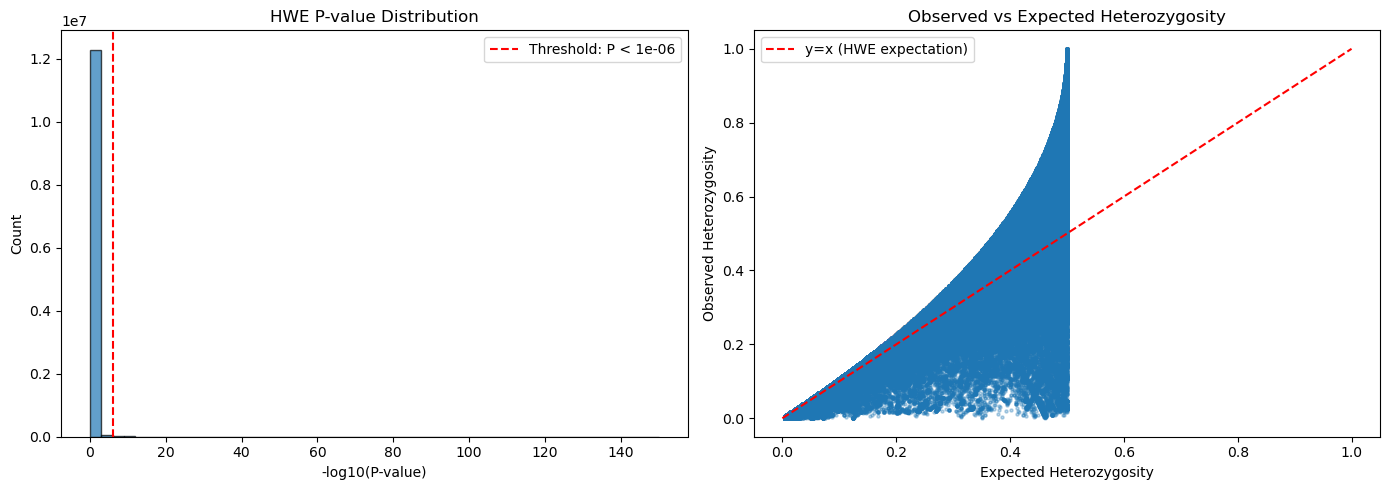

In [15]:
# Visualize HWE p-value distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# P-value histogram (log scale)
p_values = hardy_df['P'].dropna()
log_p = -np.log10(p_values + 1e-300)  # Add small value to avoid log(0)

axes[0].hist(log_p, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(-np.log10(SITUATIONAL_FILTERS.HWE_P_THRESHOLD), 
                color='red', linestyle='--', 
                label=f'Threshold: P < {SITUATIONAL_FILTERS.HWE_P_THRESHOLD}')
axes[0].set_xlabel('-log10(P-value)')
axes[0].set_ylabel('Count')
axes[0].set_title('HWE P-value Distribution')
axes[0].legend()

# Observed vs Expected heterozygosity
axes[1].scatter(
    hardy_df['E(HET_A1)'], 
    hardy_df['O(HET_A1)'], 
    alpha=0.3, s=5
)
axes[1].plot([0, 1], [0, 1], 'r--', label='y=x (HWE expectation)')
axes[1].set_xlabel('Expected Heterozygosity')
axes[1].set_ylabel('Observed Heterozygosity')
axes[1].set_title('Observed vs Expected Heterozygosity')
axes[1].legend()

plt.tight_layout()
plt.show()

In [16]:
# Apply HWE filter
hwe_output = filter_hwe(
    INPUT_PFILE,
    output_pfile=str(PATHS.PLINK_HWE_FILTERED),
    p_threshold=SITUATIONAL_FILTERS.HWE_P_THRESHOLD,
    verbose=True,
)

SITUATIONAL FILTER 1: Hardy-Weinberg Equilibrium
  P-value threshold: 1e-06
  Filter mode: keep-fewhet
  Note: This is SITUATIONAL - adjust threshold based on study design
  Input variants: 12405513
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered --hwe 1e-06 keep-fewhet --make-pgen --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered.log.
Options in effect:
  --hwe 1e-06 keep-fewhet
  --make-pgen
  --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_AND_SNP_filtered_data_MAF_filtered
  --threads 8

Start time: Sun Feb  1 09:27:48 2026
15686 MiB RAM detected, ~4969 available; reserving 4905 MiB for main workspace.
Us

## Step 2: Variant ID Standardization

Set standardized variant IDs for cross-study compatibility and FST analysis.

Format: `chrom:pos[build]ref,alt` (e.g., `12:58124534[b37]C,G`)

In [17]:
# Set variant IDs
unique_ids_output = set_variant_ids(
    hwe_output,
    output_pfile=str(PATHS.PLINK_UNIQUE_IDS),
    id_format="@:#[b37]$r,$a",
    verbose=True,
)

SITUATIONAL: Variant ID Standardization
  ID format: @:#[b37]$r,$a
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered --set-all-var-ids @:#[b37]$r,$a --make-pgen --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids.log.
Options in effect:
  --make-pgen
  --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered
  --set-all-var-ids @:#[b37]$r,$a
  --threads 8

Start time: Sun Feb  1 09:28:06 2026
15686 MiB RAM detected, ~4942 available; reserving 4878 MiB for main workspace.
Using up to 8 compute threads.
504 samples (0 females, 0 males, 504 ambiguous; 504 founders) loaded from
1000geno

## Step 3: LD Pruning

**SITUATIONAL FILTER 2**: Remove variants in high linkage disequilibrium.

### When to adjust LD parameters:
- **PCA/Structure analysis**: Aggressive pruning (window=1000kb, r²=0.1)
- **Ancestry inference**: Moderate pruning (window=500kb, r²=0.2)
- **Association studies**: Usually SKIP LD pruning

### Parameters:
- **Window**: Size of sliding window in kb
- **Step**: Number of variants to move window
- **R² threshold**: Maximum correlation allowed

In [18]:
# Test multiple LD configurations
ld_configs = [
    {"window": 1000, "step": 1, "r2": 0.1, "name": "aggressive"},
    {"window": 500, "step": 1, "r2": 0.2, "name": "moderate"},
    {"window": 100, "step": 1, "r2": 0.5, "name": "light"},
]

ld_results = {}

for config in ld_configs:
    print(f"\n>>> Testing {config['name']} LD pruning...")
    prefix = calculate_ld_prune_list(
        unique_ids_output,
        output_prefix=f"{str(PATHS.OUTPUT_DIR)}/LD_test_{config['name']}",
        window_kb=config['window'],
        step=config['step'],
        r2_threshold=config['r2'],
        verbose=True,
    )
    
    # Count variants
    with open(f"{prefix}.prune.in") as f:
        n_keep = sum(1 for _ in f)
    ld_results[config['name']] = n_keep


>>> Testing aggressive LD pruning...
SITUATIONAL FILTER 3: LD Pruning (Calculate List)
  Window: 1000 kb
  Step: 1 SNPs
  R² threshold: 0.1
  Note: This is SITUATIONAL - skip for association studies
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids --indep-pairwise 1000kb 1 0.1 --out 1000genomes/output_sea_jpt_cn/LD_test_aggressive
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/LD_test_aggressive.log.
Options in effect:
  --indep-pairwise 1000kb 1 0.1
  --out 1000genomes/output_sea_jpt_cn/LD_test_aggressive
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids
  --threads 8

Start time: Sun Feb  1 09:28:23 2026
15686 MiB RAM detected, ~4884 available; reserving 4820 MiB for main workspace.
Using up to 8 compute threads.
504 samples (0 females, 0 mal

In [19]:
# Compare LD pruning results
print("\nLD Pruning Comparison:")
print("="*60)
input_n = count_variants(unique_ids_output)
print(f"Input variants: {input_n}")
print()
for name, n_keep in ld_results.items():
    pct_keep = n_keep / input_n * 100
    print(f"  {name:15s}: {n_keep:,} variants ({pct_keep:.1f}% retained)")


LD Pruning Comparison:
Input variants: 12369941

  aggressive     : 599,223 variants (4.8% retained)
  moderate       : 1,550,767 variants (12.5% retained)
  light          : 4,009,776 variants (32.4% retained)


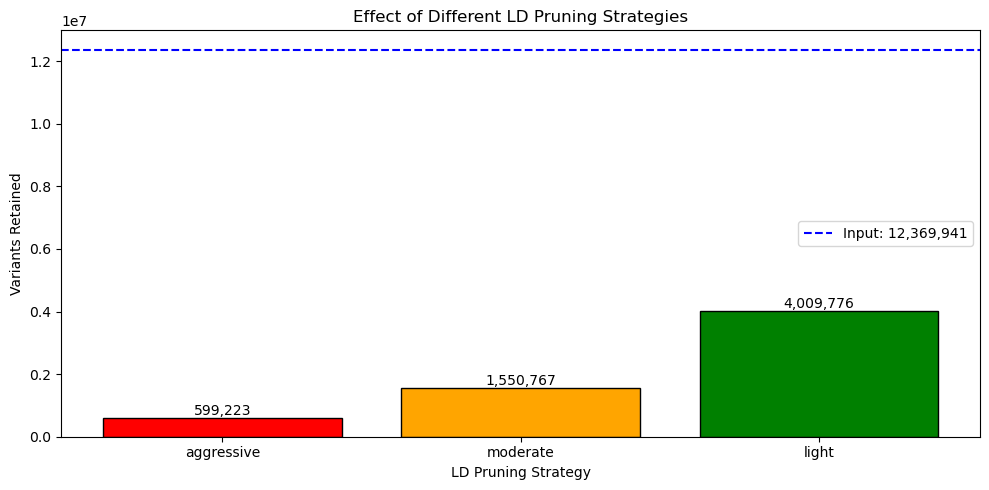

In [20]:
# Visualize LD pruning results
plt.figure(figsize=(10, 5))

names = list(ld_results.keys())
values = list(ld_results.values())

bars = plt.bar(names, values, color=['red', 'orange', 'green'], edgecolor='black')
plt.axhline(input_n, color='blue', linestyle='--', label=f'Input: {input_n:,}')

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'{val:,}', ha='center', va='bottom')

plt.xlabel('LD Pruning Strategy')
plt.ylabel('Variants Retained')
plt.title('Effect of Different LD Pruning Strategies')
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Apply aggressive LD pruning (recommended for FST/PCA)
ld_output = filter_ld(
    unique_ids_output,
    output_pfile=str(PATHS.PLINK_LD_PRUNED),
    window_kb=SITUATIONAL_FILTERS.LD_WINDOW_KB,
    step=SITUATIONAL_FILTERS.LD_STEP,
    r2_threshold=SITUATIONAL_FILTERS.LD_R2_THRESHOLD,
    verbose=True,
)

SITUATIONAL FILTER 3: LD Pruning (Calculate List)
  Window: 1000 kb
  Step: 1 SNPs
  R² threshold: 0.1
  Note: This is SITUATIONAL - skip for association studies
Running: plink2 --threads 8 --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids --indep-pairwise 1000kb 1 0.1 --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids_LD_pruned_1000kb_1_0.1
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids_LD_pruned_1000kb_1_0.1.log.
Options in effect:
  --indep-pairwise 1000kb 1 0.1
  --out 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids_LD_pruned_1000kb_1_0.1
  --pfile 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_SNP_MAF_HWE_filtered_unique_ids
  --threads 8

Start time: Sun Feb  1 09:29:55 2026
15686 MiB RAM detected, ~4780 availab

## Summary

In [22]:
print("="*60)
print("SITUATIONAL FILTERING SUMMARY")
print("="*60)
print(f"\nFilters applied:")
print(f"  1. HWE (P < {SITUATIONAL_FILTERS.HWE_P_THRESHOLD}): SITUATIONAL")
print(f"  2. Variant ID standardization")
print(f"  3. LD pruning ({SITUATIONAL_FILTERS.LD_WINDOW_KB}kb, r²={SITUATIONAL_FILTERS.LD_R2_THRESHOLD}): SITUATIONAL")
print(f"\nVariant counts:")
print(f"  Input (after hard filters): {count_variants(INPUT_PFILE)}")
print(f"  After HWE: {count_variants(hwe_output)}")
print(f"  After LD pruning: {count_variants(ld_output)}")
print(f"\nOutput file: {ld_output}")
print(f"\nNext step: Run 03_fst_and_pca.ipynb")

SITUATIONAL FILTERING SUMMARY

Filters applied:
  1. HWE (P < 1e-06): SITUATIONAL
  2. Variant ID standardization
  3. LD pruning (1000kb, r²=0.1): SITUATIONAL

Variant counts:
  Input (after hard filters): 12405513
  After HWE: 12369941
  After LD pruning: 599223

Output file: 1000genomes/output_sea_jpt_cn/SEA_JPT_CN_FINAL_DATA_FOR_FST

Next step: Run 03_fst_and_pca.ipynb
